# News Article Similarity Analysis

In [1]:
# import required packages for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nltk

#from nltk.corpus import stopwords # not used but can be for furhter comparative analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from statsmodels.stats.proportion import proportions_ztest
from random import sample
from tqdm import tqdm # progress bar

In [2]:
# import data
df = pd.read_csv('news_articles.csv')
df.head()

,company,date,article,link
0,Netflix,2023-02-24,"SINGAPORE, Feb 24 (Reuters) - U.S streaming gi...",https://www.reuters.com/technology/netflix-mak...
1,Netflix,2023-02-24,Feb 23 (Reuters) - Wall Street ended a topsy-t...,https://www.reuters.com/markets/us/futures-ris...
2,Netflix,2023-02-23,"MEXICO CITY, Feb 23 (Reuters) - Grupo Televisa...",https://www.reuters.com/business/media-telecom...
3,Netflix,2023-02-23,Feb 23 (Reuters) - Netflix Inc (NFLX.O) said o...,https://www.reuters.com/business/media-telecom...
4,Netflix,2023-02-23,"BRUSSELS, Feb 23 (Reuters) - The European Comm...",https://www.reuters.com/technology/eu-eyes-big...


In [3]:
# split into before and after ChatGPT launched
df0 = df[df['date'].astype('datetime64[ns]') < '2022-12-01']
df1 = df[df['date'].astype('datetime64[ns]') >= '2022-12-01']

In [4]:
# see how the article numbers split
print('Articles wirtten before ChatGPT:\n',df0.company.value_counts().sort_index(ascending=True),sep='')
print('\nArticles wirtten after:\n',df1.company.value_counts().sort_index(ascending=True),sep='')

Articles wirtten before ChatGPT:
Apple        290
Google       179
Microsoft    128
Netflix       69
Tesla        330
Twitter      525
Name: company, dtype: int64

Articles wirtten after:
Apple        196
Google       166
Microsoft    193
Netflix       39
Tesla        338
Twitter      265
Name: company, dtype: int64


In [5]:
df1.company.unique()

array(['Netflix', 'Microsoft', 'Apple', 'Twitter', 'Google', 'Tesla'],
      dtype=object)

In [6]:
# make a list of the dataframe names
frames = []

for company in df1.company.unique():
    frames.append(company + '0')
    frames.append(company + '1')

In [7]:
# put datafames into a dictionary
dframes = {}
for frame in frames:
    if frame[-1] == '0':
        dframes[frame] = df0[df0['company'] == frame[:-1]]
        
    elif frame[-1] == '1':
        dframes[frame] = df1[df1['company'] == frame[:-1]]

In [8]:
dframes['Google0'].head() # make sure it's working as intended

,company,date,article,link
1871,Google,2022-11-30,Nov 30 (Reuters) - Salesforce Inc (CRM.N) said...,https://www.reuters.com/technology/salesforce-...
1872,Google,2022-11-30,"LAS VEGAS, Nov 30 (Reuters) - Amazon.com Inc (...",https://www.reuters.com/technology/amazon-warn...
1873,Google,2022-11-30,Nov 30 (Reuters) - French IT consulting firm A...,https://www.reuters.com/technology/aws-atos-an...
1874,Google,2022-11-30,"NEW YORK, Nov 30 (Reuters) - U.S. Treasury Sec...",https://www.reuters.com/technology/us-treasury...
1875,Google,2022-11-30,"LONDON, Nov 30 (Reuters) - Google was sued on ...",https://www.reuters.com/technology/google-face...


### Dataframes loaded - now we need to take samples from each to control for articles written about the same topics

In [9]:
n = 30 # Netflix only had 39 articles from December thru February. Unless Netflix is removed from the analysis, 39 is the max sample that can be taken
ran_state = 1 # for replicability

def compute_similarity(a, b):
    vectorizer = TfidfVectorizer() # tokenizes words and makes them lower case automatically
    tfidf = vectorizer.fit_transform([a, b])

    return ((tfidf * tfidf.T).toarray())[0,1] # same as cosines_imilarity

In [10]:
Google0s = dframes['Google0'].sample(n=n, random_state=ran_state).reset_index()

Google1s = dframes['Google1'].sample(n=n, random_state=ran_state).reset_index()


In [11]:
Netflix0s = dframes['Netflix0'].sample(n=n, random_state=ran_state).reset_index()

Netflix1s = dframes['Netflix1'].sample(n=n, random_state=ran_state).reset_index()


In [12]:
Tesla0s = dframes['Tesla0'].sample(n=n, random_state=ran_state).reset_index()

Tesla1s = dframes['Tesla1'].sample(n=n, random_state=ran_state).reset_index()


In [13]:
Twitter0s = dframes['Twitter0'].sample(n=n, random_state=ran_state).reset_index()

Twitter1s = dframes['Twitter1'].sample(n=n, random_state=ran_state).reset_index()

In [14]:
Apple0s = dframes['Apple0'].sample(n=n, random_state=ran_state).reset_index()

Apple1s = dframes['Apple1'].sample(n=n, random_state=ran_state).reset_index()

In [15]:
Microsoft0s = dframes['Microsoft0'].sample(n=n, random_state=ran_state).reset_index()

Microsoft1s = dframes['Microsoft1'].sample(n=n, random_state=ran_state).reset_index()

In [16]:
sframes = [Twitter0s, Twitter1s, Tesla0s, Tesla1s, Google0s, Google1s, Microsoft0s, Microsoft1s, Apple0s, Apple1s, Netflix0s, Netflix1s]

Matrices = {}

M_names = ['Twitter0s', 'Twitter1s', 'Tesla0s', 'Tesla1s', 'Google0s', 'Google1s', 'Microsoft0s', 'Microsoft1s', 'Apple0s', 'Apple1s', 'Netflix0s', 'Netflix1s']

### Sample Dataframes created - now we find the cosine similarities by creating matrices

In [17]:
for d in range(len(sframes)):

    Matrices[M_names[d]] = np.zeros((sframes[d].shape[0], sframes[d].shape[0])) # we create a 30x30 matrix to contain the results of article_i with article_j

    for i, row in tqdm(sframes[d].iterrows(), total=sframes[d].shape[0], desc='1st level'): # we define i
        for j, next_row in sframes[d].iterrows(): # we define j
            Matrices[M_names[d]][i, j] = compute_similarity(row.article, next_row.article) # we populate the matrix with the results


1st level: 100%|██████████| 30/30 [00:01<00:00, 15.64it/s]


In [18]:
Matrices.keys() # make sure the code worked properly - key names should be the same as the sample dataframe names

dict_keys(['Twitter0s', 'Twitter1s', 'Tesla0s', 'Tesla1s', 'Google0s', 'Google1s', 'Microsoft0s', 'Microsoft1s', 'Apple0s', 'Apple1s', 'Netflix0s', 'Netflix1s'])

In [19]:
# since articles will be necessarily exaclty similar to themesleves (i.e. 1) we remove 1s from diagonal in each matrix

for m in Matrices:
    np.fill_diagonal(Matrices[m], np.nan)

In [20]:
#count prportion of highly similar articles by subject - since it's a matrix, need to half the number and the denominator is ((n*n)-n)/2

for m in Matrices:
    if len(m) < 9:
        print(m + ' ', ((Matrices[m] > .45).sum() // 2), round(((Matrices[m] > .45).sum() // 2) / ((900-30)/2),4), sep='\t')
    else:
        print(m, ((Matrices[m] > .45).sum() // 2), round(((Matrices[m] > .45).sum() // 2) / ((900-30)/2),4), sep='\t')

Twitter0s	129	0.2966
Twitter1s	187	0.4299
Tesla0s 	285	0.6552
Tesla1s 	306	0.7034
Google0s 	214	0.492
Google1s 	275	0.6322
Microsoft0s	327	0.7517
Microsoft1s	329	0.7563
Apple0s 	206	0.4736
Apple1s 	253	0.5816
Netflix0s	279	0.6414
Netflix1s	366	0.8414


Looks like there is an increase in the proportion of articles that are highly similar after the advent of ChatGPT - let's visual and test if it is significant

## Define function to plot heatmaps of similiarities

In [21]:
def plot_heatmaps(company, dataframe0, dataframe1, matrix0, matrix1):
    
    labels = dataframe0.link.str.split('/').str[-2].str[:20].str.replace('-',' ').str.upper() # we extract part of the titles of the articles from the url
    similarity_df = pd.DataFrame(matrix0, columns=labels, index=labels) # let's create the dataframe
    top = similarity_df[similarity_df > .45]
    mask = np.triu(np.ones_like(top)) # we apply a mask to remove duplicate values


    # let's create the viz
    fig, axes = plt.subplots(1,2,figsize=(20, 10))

    sns.heatmap(ax=axes[0],
                data=top,
                square=True, 
                annot=True, 
                robust=True,
                fmt='.2f',
                annot_kws={'size': 6, 'fontweight': 'bold'},
                yticklabels=similarity_df.columns,
                xticklabels=similarity_df.columns,
                cmap="mako_r",
                mask=mask,
                vmin=.4,
                vmax=.8,
                cbar=False
    )
    axes[0].set(title='Before ChatGPT',
                ylabel='Article',
                xlabel='Article',)

    #axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 45, horizontalalignment='right')
    
    labels = dataframe1.link.str.split('/').str[-2].str[:20].str.replace('-',' ').str.upper() #Google1s.link.str.split('/').str[-2].str[:15] # we extract the titles of the articles from the url
    similarity_df = pd.DataFrame(matrix1, columns=labels, index=labels) # let's create the dataframe
    top = similarity_df[similarity_df > .45]
    mask = np.triu(np.ones_like(top))

    sns.heatmap(ax=axes[1],
                data=top,
                square=True, 
                annot=True, 
                robust=True,
                fmt='.2f',
                annot_kws={'size': 6, 'fontweight': 'bold'},
                yticklabels=similarity_df.columns,
                xticklabels=similarity_df.columns,
                cmap="mako_r",
                mask=mask,
                vmin=.4,
                vmax=.8,
                cbar=False
    )
    axes[1].set(title='After ChatGPT',
                ylabel='Article',
                xlabel='Article')


    plt.suptitle('Similarity Heatmaps - ' + company + '\n', fontsize=24)
    plt.tight_layout()
    plt.show()
    fig.savefig(company + '_heatmaps.svg') # save files for the heatmaps
    fig.savefig(company + '_heatmaps.pdf')

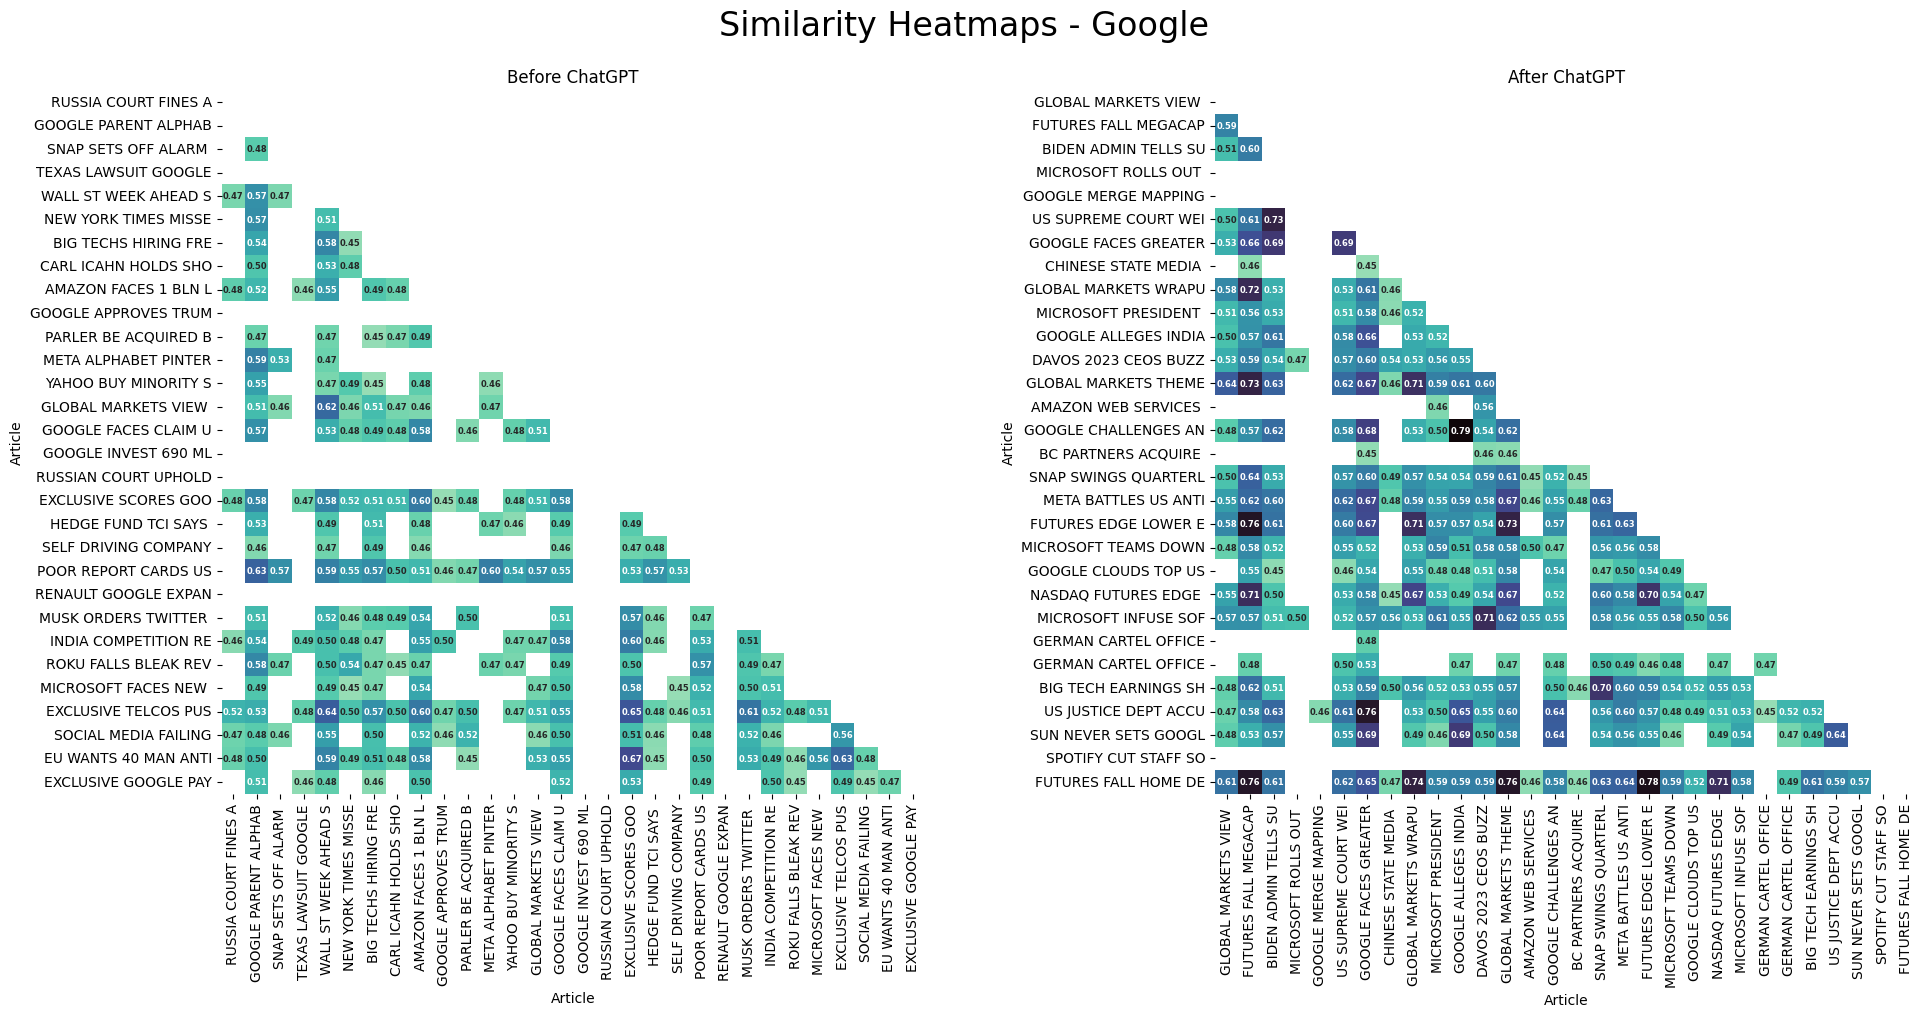

In [22]:
plot_heatmaps('Google', Google0s, Google1s, Matrices['Google0s'], Matrices['Google1s'])

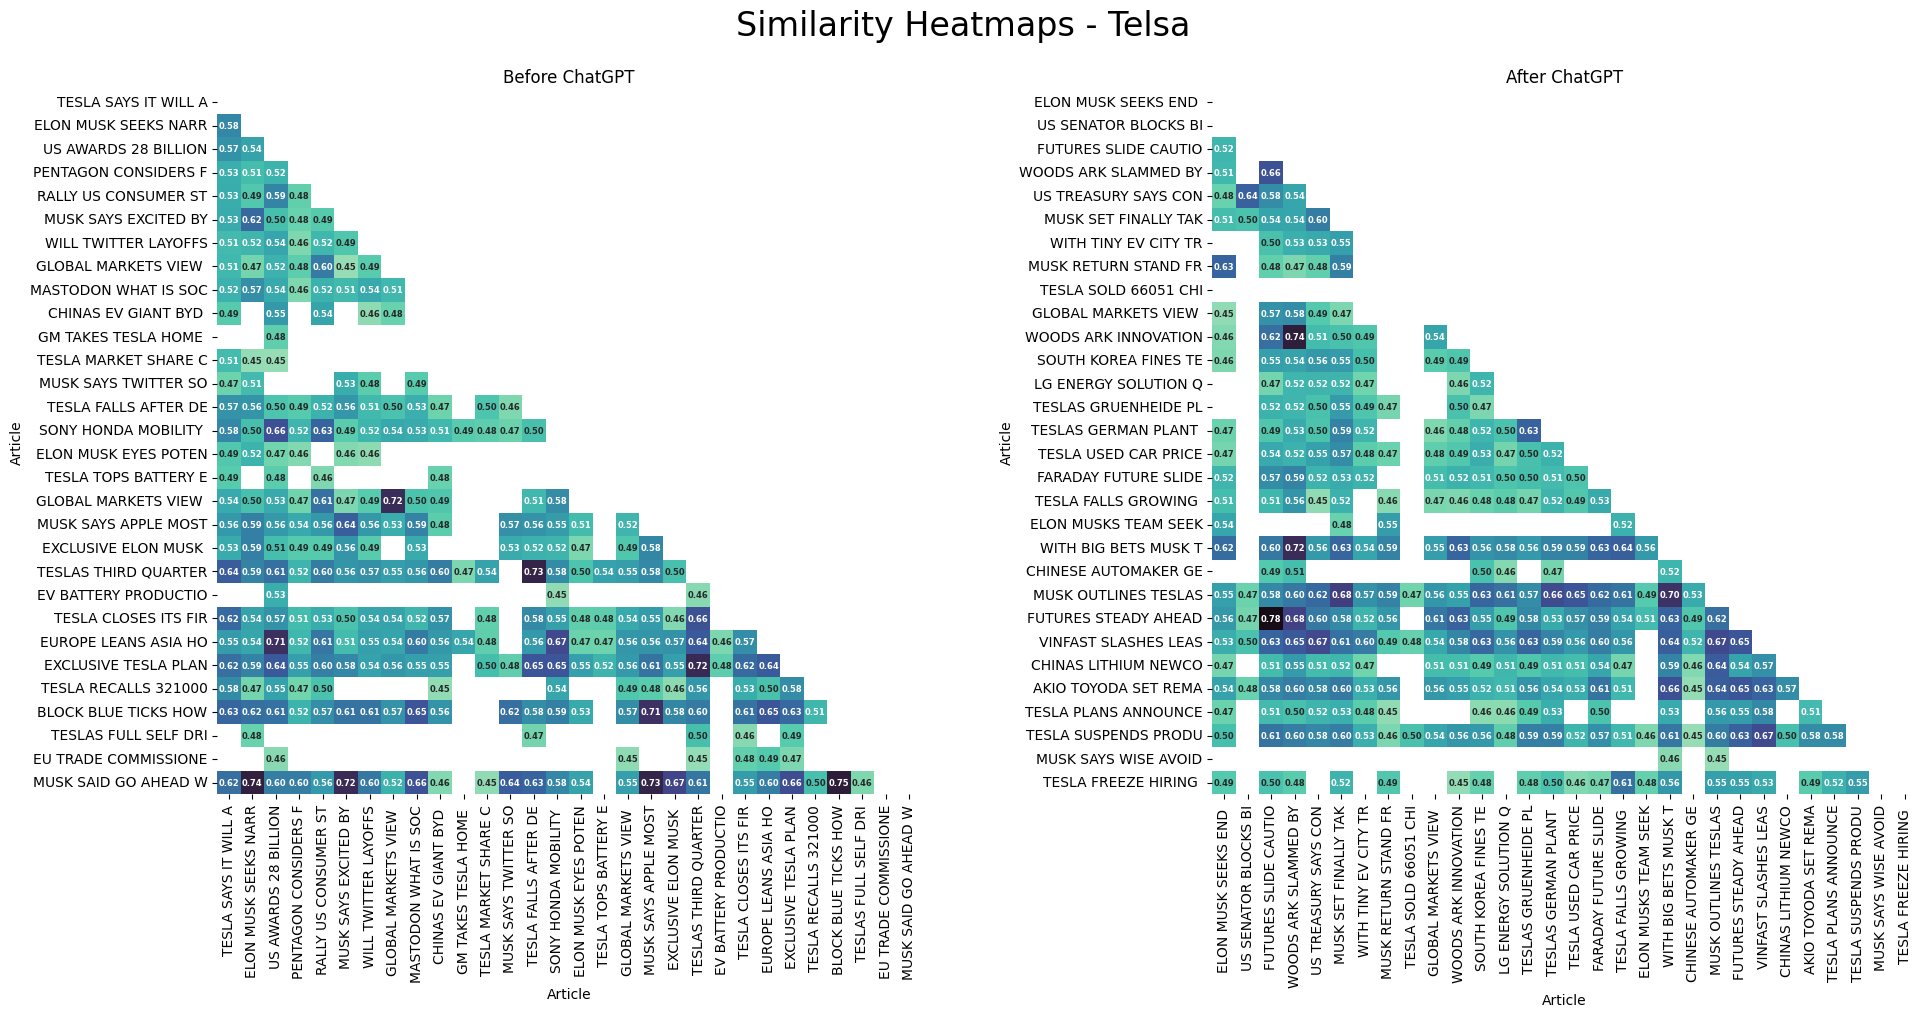

In [23]:
plot_heatmaps('Telsa', Tesla0s, Tesla1s, Matrices['Tesla0s'], Matrices['Tesla1s'])

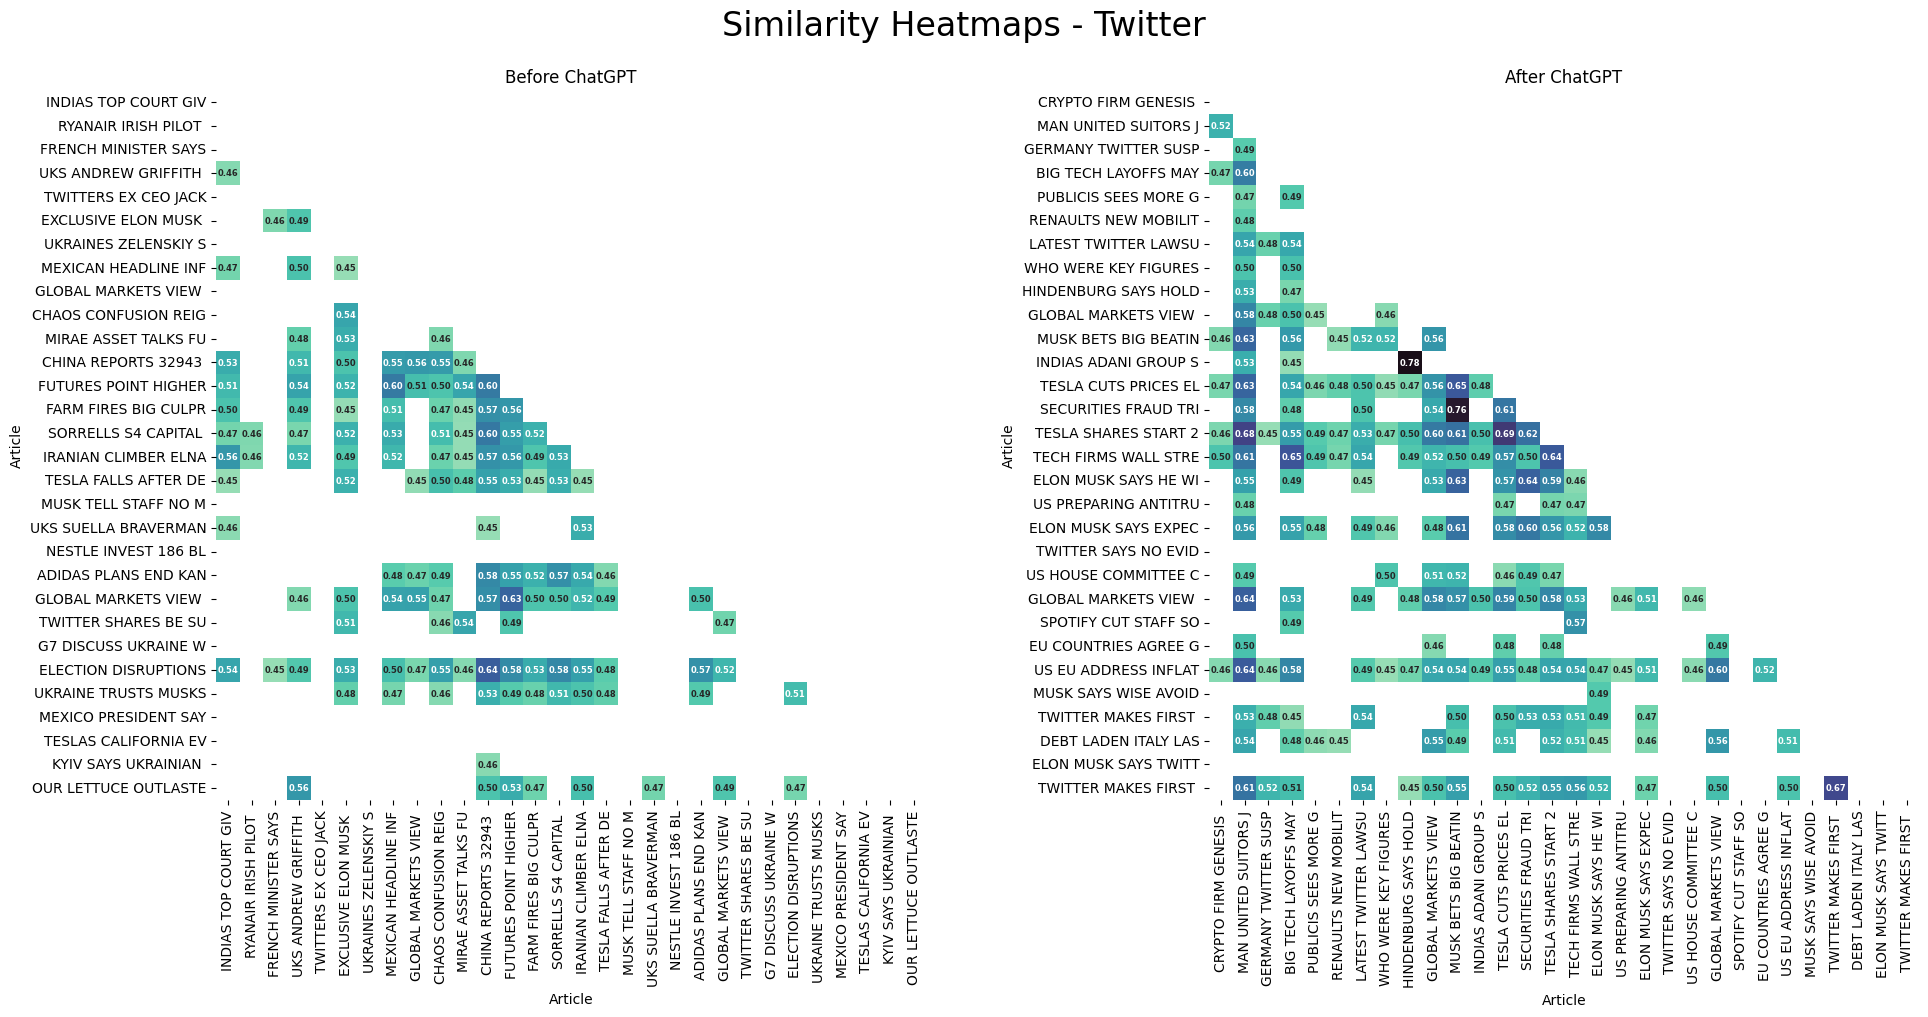

In [24]:
plot_heatmaps('Twitter', Twitter0s, Twitter1s, Matrices['Twitter0s'], Matrices['Twitter1s'])

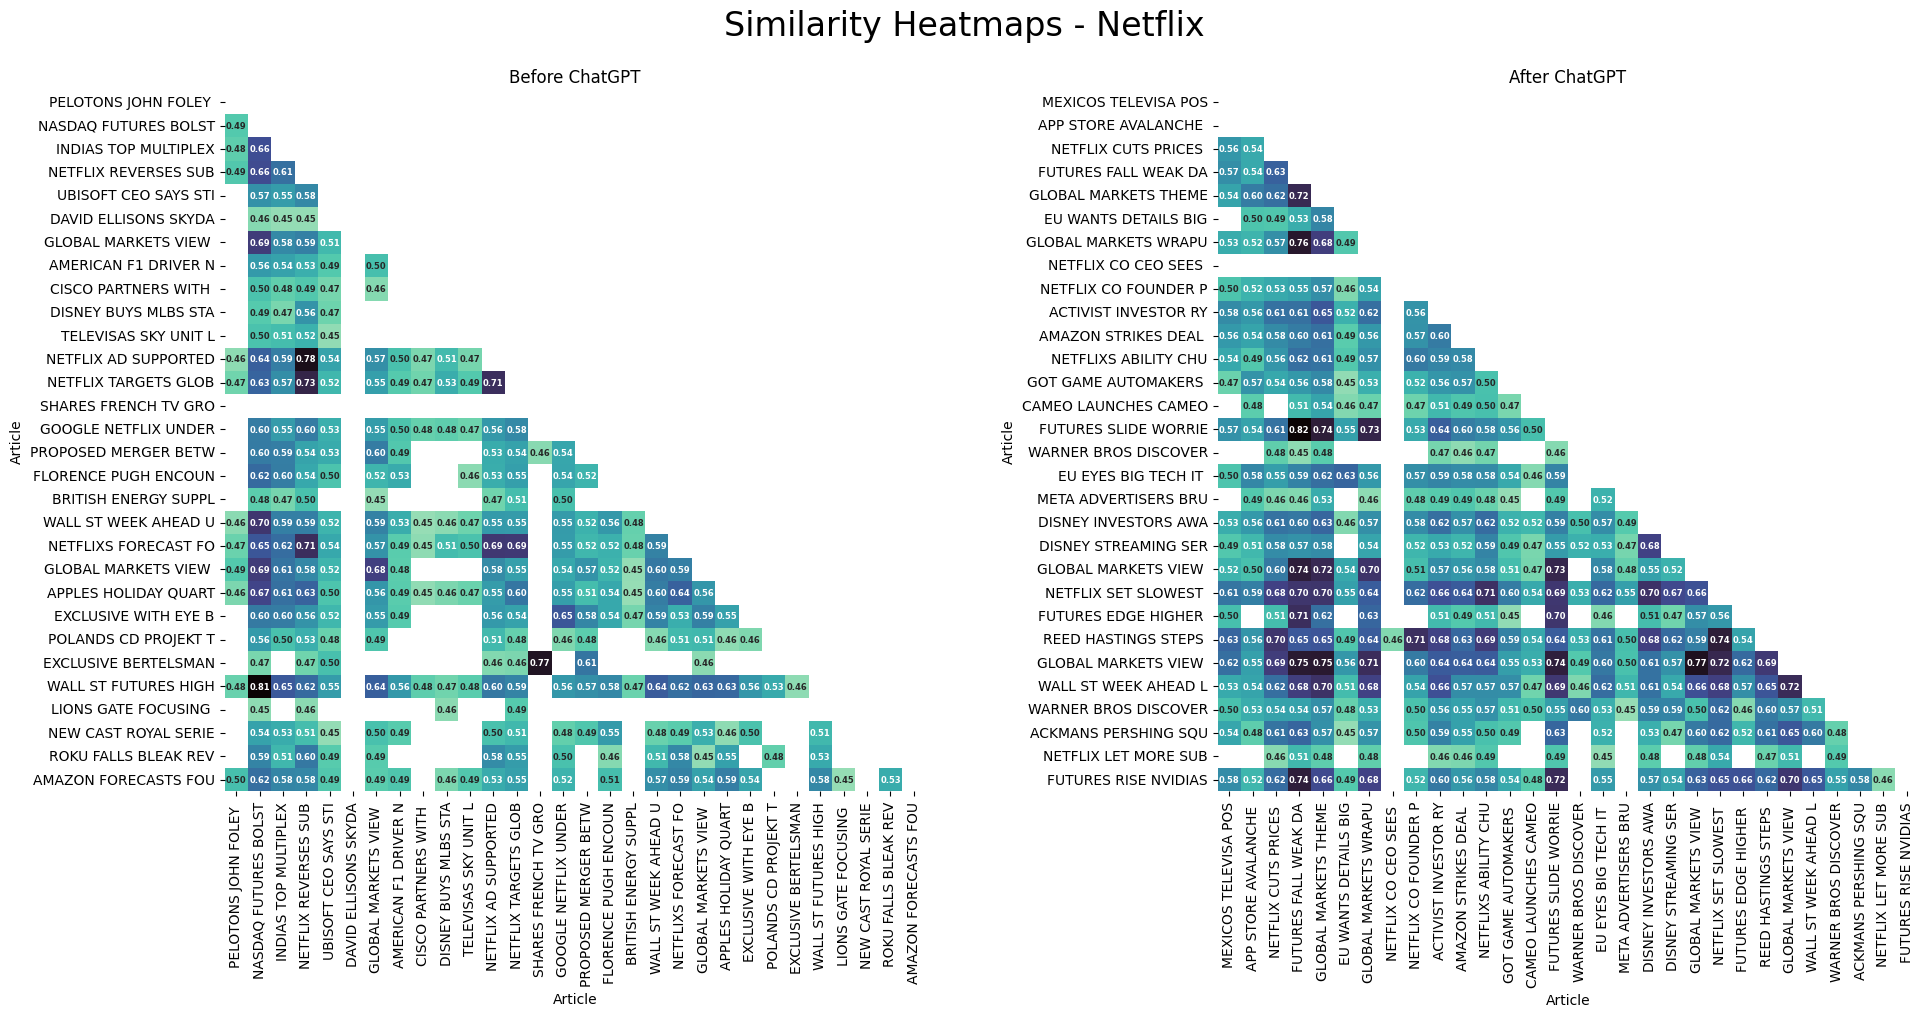

In [25]:
plot_heatmaps('Netflix', Netflix0s, Netflix1s, Matrices['Netflix0s'], Matrices['Netflix1s'])

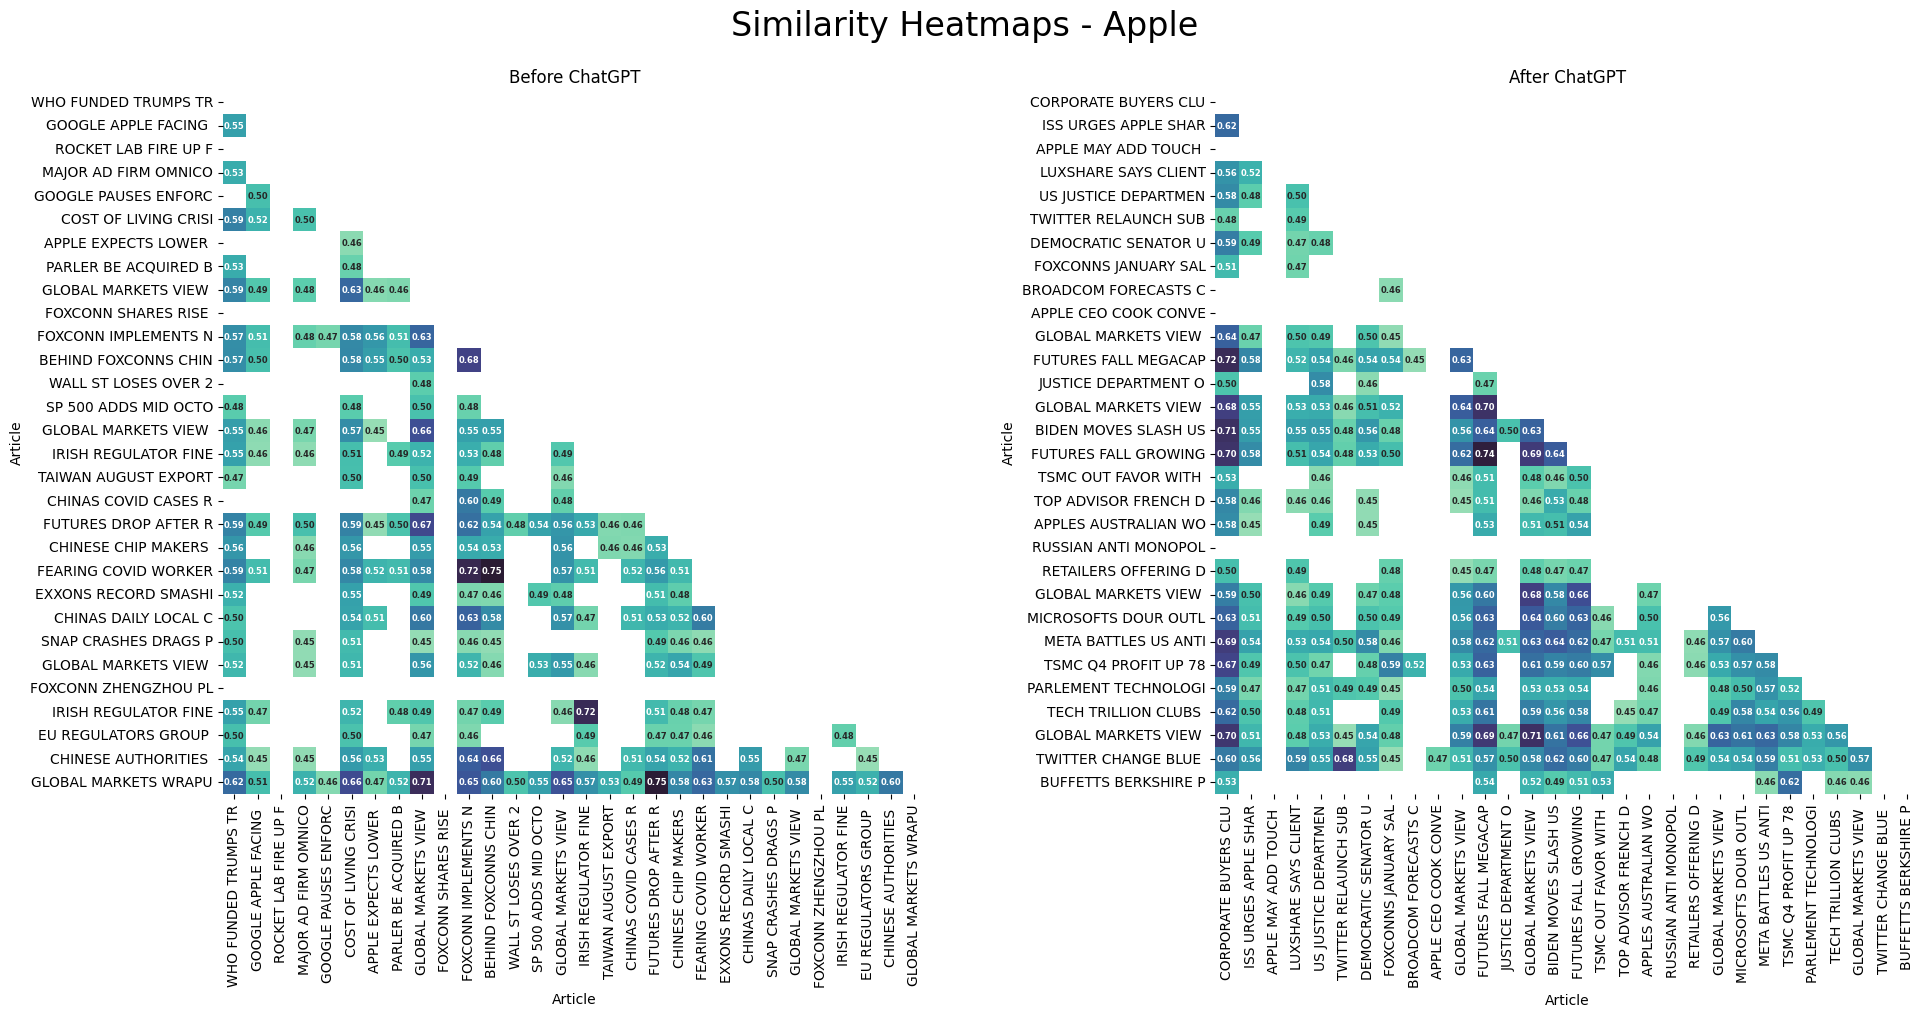

In [26]:
plot_heatmaps('Apple', Apple0s, Apple1s, Matrices['Apple0s'], Matrices['Apple1s'])

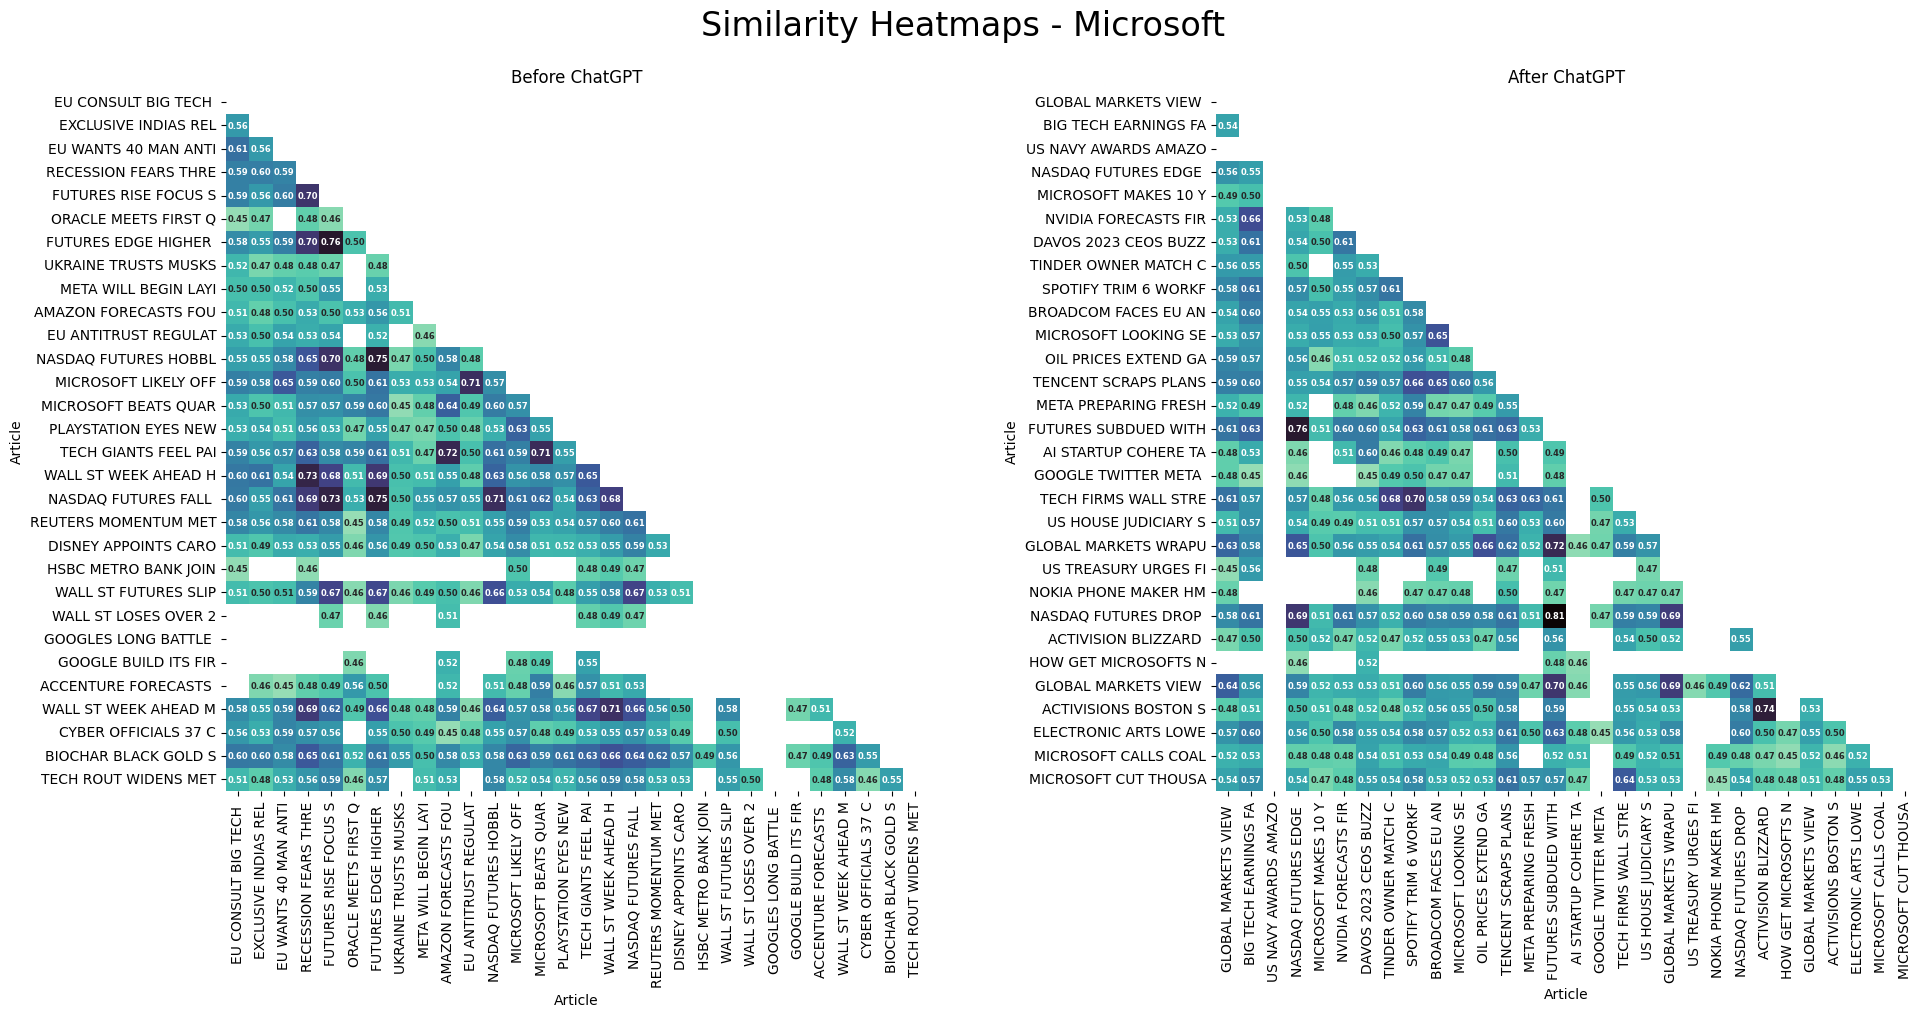

In [27]:
plot_heatmaps('Microsoft', Microsoft0s, Microsoft1s, Matrices['Microsoft0s'], Matrices['Microsoft1s'])

In [28]:
# define function to test if the proportion of similar articles increased

def proportion_test(company):
    s = (900-30) / 2 
    m0 = company + '0s'
    m1 = company + '1s'
    M0 = Matrices[m0]
    M1 = Matrices[m1]
    x0 = ((M0 > .45).sum() // 2)
    x1 = ((M1 > .45).sum() // 2)
    n1 = s
    n2 = s
    print(company, x0, x1)
    success_cnts = np.array([x0, x1])
    total_cnts = np.array([n1, n2])
    test_stat, pval = proportions_ztest(count=success_cnts, nobs=total_cnts, alternative='smaller')
    print('One sided z-test: z = {:.4f}, p-value = {:.4f}'.format(test_stat, pval))
    print()

In [29]:
for c in df1.company.unique():
    proportion_test(c)

Netflix 279 366
One sided z-test: z = -6.7361, p-value = 0.0000

Microsoft 327 329
One sided z-test: z = -0.1574, p-value = 0.4374

Apple 206 253
One sided z-test: z = -3.1918, p-value = 0.0007

Twitter 129 187
One sided z-test: z = -4.0887, p-value = 0.0000

Google 214 275
One sided z-test: z = -4.1684, p-value = 0.0000

Tesla 285 306
One sided z-test: z = -1.5254, p-value = 0.0636



In [30]:
# looks like for 5 of the 6 companies, the proportion did increase. Let's see if the overal similarities did as well 
# we'll conduct a one sided t-test to see if the average cosine similarity score increased

def mean_t_test(company):
    m0 = company + '0s'
    m1 = company + '1s'
    M0 = Matrices[m0]
    M1 = Matrices[m1]
    
    x0 = np.nanmean(M0)
    x1 = np.nanmean(M1)
    
    s0 = np.nanstd(M0)
    s1 = np.nanstd(M1)
    
    n0 = 900-30
    n1 = n0
    
    df = n0 + n1 - 2
    
    v0 = np.nanvar(M0)
    v1 = np.nanvar(M1)
    
    v = ((n0-1)*v0 + (n1-1)*v1)/(n0+n1-2)
    
    test_stat = (x1 - x0)/v*np.sqrt((1/n0+1/n1))
    
    p_val = stats.t.sf(abs(test_stat), df=df)
    
    print(company)
    print('One sided t-test: t = {:.4f}, p-value = {:.4f}'.format(test_stat, p_val))
    print()

In [31]:
for c in df1.company.unique():
    mean_t_test(c)

Netflix
One sided t-test: t = 0.3201, p-value = 0.3745

Microsoft
One sided t-test: t = -0.0415, p-value = 0.4835

Apple
One sided t-test: t = 0.1458, p-value = 0.4420

Twitter
One sided t-test: t = 0.2467, p-value = 0.4026

Google
One sided t-test: t = 0.2878, p-value = 0.3868

Tesla
One sided t-test: t = 0.0327, p-value = 0.4870



The average cosine simiarities did not increase across all articles, but the proportion of highly similar articles did. This is what we would expect from more AI generated articles - many articles are still be written by humans, so the diversity across all them is still high, but are more likely to see less diversity between two randomly selected articles